# Training Section

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
import pandas as pd
import numpy as np

# 1. Load and average events per slot
df = pd.read_csv('cityD-dataset.csv')
df['timestamp'] = df['d'] * 48 + df['t']
df_avg = (
    df.groupby(['uid','timestamp'])[['x','y']]
      .mean()
      .reset_index()
)

# 2. Determine full timeline length (should be 76*48=3648 if days 0–75)
T_all = df_avg['timestamp'].max() + 1  # e.g. 3648

# 3. Create dense grid for each user
uids      = df_avg['uid'].unique()
grid_data = []
for uid in uids:
    user = df_avg[df_avg['uid']==uid].set_index('timestamp')
    full = (
        user
        .reindex(np.arange(T_all))        # 0 … T_all-1
        .fillna(method='ffill')           # carry last known loc forward
        .fillna(0)                        # start-gaps → (0,0)
        [['x','y']]
        .values                           # shape = (T_all,2)
    )
    grid_data.append(full)

data = np.stack(grid_data)  # shape = (U, T_all, 2)


串流輸出內容已截斷至最後 5000 行。
<ipython-input-2-134999defdc5>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')           # carry last known loc forward
<ipython-input-2-134999defdc5>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')           # carry last known loc forward
<ipython-input-2-134999defdc5>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')           # carry last known loc forward
<ipython-input-2-134999defdc5>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')           # carry last known loc forward
<ipython-input-2-134999defd

In [ ]:
len(df)

8418135

In [ ]:
df.uid.nunique()

6000

In [ ]:
# train_df = df[df['d'] <= 60]
# val_df   = df[df['d'] >= 61]

In [ ]:
# print(len(train_df))
# print(len(val_df))

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# define cut-offs
HIST = 60 * 48   # 60 days of history = 2880 steps
PRED = data.shape[1] - HIST   # days 60–75 = 16 days = 768 steps

class MobilityDataset(Dataset):
    def __init__(self, data):
        # data.shape == (U, T_all, 2)
        self.src = torch.from_numpy(data[:, :HIST, :]).float()   # (U,2880,2)
        self.trg = torch.from_numpy(data[:, HIST:HIST+PRED, :]).float()  # (U,768,2)
        print("src:", self.src.shape, " trg:", self.trg.shape)

    def __len__(self):
        return self.src.size(0)

    def __getitem__(self, i):
        return self.src[i], self.trg[i]

ds     = MobilityDataset(data)
loader = DataLoader(ds, batch_size=16, shuffle=True)


src: torch.Size([6000, 2880, 2])  trg: torch.Size([6000, 720, 2])


In [ ]:
import torch.nn as nn

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc      = nn.Linear(hidden_size, input_size)

    def forward(self, src):
        _, (h, c) = self.encoder(src)
        dec_in = src[:, -1:, :]  # last observed slot
        outputs = []
        for _ in range(PRED):
            out, (h, c) = self.decoder(dec_in, (h, c))
            step = self.fc(out)
            outputs.append(step)
            dec_in = step
        return torch.cat(outputs, dim=1)  # (batch, 768, 2)


In [ ]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = Seq2SeqLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 20
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0
    for batch_idx, (src, trg) in enumerate(loader, 1):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        out = model(src)
        loss = criterion(out, trg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f"[Train] Epoch {epoch}/{num_epochs} Batch {batch_idx}/{len(loader)} Loss: {loss.item():.4f}")
    print(f"→ Epoch {epoch} Average Loss: {total_loss/len(loader):.4f}")

[Train] Epoch 1/20 Batch 1/375 Loss: 14801.2158
[Train] Epoch 1/20 Batch 2/375 Loss: 10838.8848
[Train] Epoch 1/20 Batch 3/375 Loss: 14557.1250
[Train] Epoch 1/20 Batch 4/375 Loss: 10345.0664
[Train] Epoch 1/20 Batch 5/375 Loss: 13360.6973
[Train] Epoch 1/20 Batch 6/375 Loss: 11587.5215
[Train] Epoch 1/20 Batch 7/375 Loss: 12756.6602
[Train] Epoch 1/20 Batch 8/375 Loss: 14741.9756
[Train] Epoch 1/20 Batch 9/375 Loss: 14229.3115
[Train] Epoch 1/20 Batch 10/375 Loss: 13179.2070
[Train] Epoch 1/20 Batch 11/375 Loss: 11374.1943
[Train] Epoch 1/20 Batch 12/375 Loss: 10885.6465
[Train] Epoch 1/20 Batch 13/375 Loss: 13452.4473
[Train] Epoch 1/20 Batch 14/375 Loss: 12526.3809
[Train] Epoch 1/20 Batch 15/375 Loss: 12221.2822
[Train] Epoch 1/20 Batch 16/375 Loss: 14734.5156
[Train] Epoch 1/20 Batch 17/375 Loss: 11312.9648
[Train] Epoch 1/20 Batch 18/375 Loss: 10974.0234
[Train] Epoch 1/20 Batch 19/375 Loss: 13958.8945
[Train] Epoch 1/20 Batch 20/375 Loss: 12151.9893
[Train] Epoch 1/20 Batch 21/3

KeyboardInterrupt: 

In [ ]:
import torch

# assume you already have:
#   data   : numpy array of shape (num_users, T_all, 2)
#   model  : your trained Seq2SeqLSTM on CUDA or CPU
#   device : torch.device('cuda' or 'cpu')
#   HIST   : 60*48 = 2880

# 1) pick the user index
user_idx = 0   # e.g. first user; change as needed

# 2) extract just their history (days 0–59) and move to device
src = torch.from_numpy(
    data[user_idx : user_idx+1, :HIST, :]   # shape (1,2880,2)
).float().to(device)

# 3) switch to eval & disable grad
model.eval()
with torch.no_grad():
    pred = model(src)   # -> shape (1, PRED, 2), where PRED = data.shape[1] - HIST = 720

# 4) convert to NumPy and reshape into (days, 48 slots, 2 coords)
pred_np = pred.squeeze(0).cpu().numpy()     # now shape (720,2)
num_days = pred_np.shape[0] // 48           # = 720/48 = 15
pred_np = pred_np.reshape(num_days, 48, 2)  # -> (15 days, 48 slots/day, 2)

# pred_np[d][t] is the (x,y) prediction for day d (0→day 60) at slot t (0–47)
print(f"Forecast shape: {pred_np.shape}")    # (15, 48, 2)


Forecast shape: (15, 48, 2)


In [ ]:
# 1. Save only the weights (recommended)
import torch
torch.save(model.state_dict(), 'model_weights.pth')

# — or — save the entire model (if you want class + weights)
torch.save(model, 'full_model.pth')

# 2. Trigger browser download
from google.colab import files
files.download('full_model.pth')   # or 'full_model.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prediction Section

In [ ]:
import torch, torch.nn as nn

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=2, pred_len=720):
        super().__init__()
        self.pred_len = pred_len
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc      = nn.Linear(hidden_size, input_size)

    def forward(self, src):
        _, (h, c) = self.encoder(src)
        dec_in = src[:, -1:, :]
        outs = []
        for _ in range(self.pred_len):
            out, (h, c) = self.decoder(dec_in, (h, c))
            step = self.fc(out)
            outs.append(step)
            dec_in = step
        return torch.cat(outs, dim=1)  # (batch, pred_len, 2)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = Seq2SeqLSTM().to(device)
model.load_state_dict(torch.load('model_weights.pth', map_location=device))
model.eval()


Seq2SeqLSTM(
  (encoder): LSTM(2, 128, num_layers=2, batch_first=True)
  (decoder): LSTM(2, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
import torch
import numpy as np

# 1) Make sure these match your training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIST   = 60 * 48                   # 2880 steps (days 0–59)
PRED   = data.shape[1] - HIST      # 3600–2880 = 720 steps (days 60–74)
batch_size = 16

# 2) Put the model in eval mode
model.eval()
model.to(device)

# 3) Build a tensor of all users’ history
#    shape = (num_users, 2880, 2)
src_all = torch.from_numpy(data[:, :HIST, :]).float().to(device)

# 4) Run inference in batches
all_preds = []
with torch.no_grad():
    for i in range(0, src_all.size(0), batch_size):
        batch = src_all[i : i+batch_size]      # (B, 2880, 2)
        out   = model(batch)                   # (B, 720, 2)
        all_preds.append(out.cpu())

# 5) Concatenate and reshape
all_preds = torch.cat(all_preds, dim=0).numpy()  # (num_users, 720, 2)
num_days  = PRED // 48                           # should be 15
all_preds = all_preds.reshape(-1, num_days, 48, 2)

print("all_preds.shape =", all_preds.shape)       # (6000, 15, 48, 2)
# all_preds[u, d, t] is the (x,y) for user u on day d (0→day 60) at slot t (0–47)


all_preds.shape = (6000, 15, 48, 2)


In [ ]:
import pandas as pd

# Grab user #0’s forecast: shape = (15 days, 48 slots, 2 coords)
user0 = all_preds[0]

# 1) Quick console‐print of the raw array for day 60
print("Day 60 predictions (48 slots of x,y):")
print(user0[0])

# 2) Or tabulate a few rows in a DataFrame
#    Flatten into (720 rows, 2 cols) with day & slot labels
rows = []
for day in range(user0.shape[0]):
    for slot in range(user0.shape[1]):
        x,y = user0[day, slot]
        rows.append({'day':60+day, 'slot':slot, 'x':x, 'y':y})
df0 = pd.DataFrame(rows)

# Show the first 10 predictions
df0.head(10)


Day 60 predictions (48 slots of x,y):
[[118.49095  109.81098 ]
 [118.249275 119.0111  ]
 [118.10462  119.46097 ]
 [117.576065 117.96775 ]
 [117.69951  117.586266]
 [117.69641  117.43755 ]
 [117.57355  117.235886]
 [117.40898  117.02037 ]
 [117.245705 116.79785 ]
 [117.126366 116.501526]
 [117.143166 115.79512 ]
 [117.011665 114.15424 ]
 [116.41876  112.068054]
 [116.12806  110.83728 ]
 [116.10128  110.25725 ]
 [116.14863  109.89066 ]
 [116.471855 109.68048 ]
 [117.47912  109.732346]
 [118.40625  109.79513 ]
 [118.82261  109.72174 ]
 [118.9692   109.58624 ]
 [119.02871  109.45543 ]
 [119.06356  109.34135 ]
 [119.10946  109.2193  ]
 [119.23519  109.02483 ]
 [119.46229  108.762474]
 [119.714455 108.52234 ]
 [119.92125  108.34398 ]
 [120.0644   108.214584]
 [120.155785 108.115776]
 [120.21286  108.036194]
 [120.249084 107.96922 ]
 [120.27302  107.91085 ]
 [120.28973  107.85851 ]
 [120.30212  107.810555]
 [120.31187  107.76597 ]
 [120.32     107.72407 ]
 [120.327034 107.684326]
 [120.33335 

,day,slot,x,y
0,60,0,118.490952,109.810982
1,60,1,118.249275,119.011101
2,60,2,118.104622,119.460968
3,60,3,117.576065,117.967751
4,60,4,117.699509,117.586266
5,60,5,117.696411,117.437553
6,60,6,117.573547,117.235886
7,60,7,117.408981,117.020370
8,60,8,117.245705,116.797852
9,60,9,117.126366,116.501526


In [ ]:
import numpy as np

# true values for days 60–74: shape = (6000, 720, 2)
true = data[:, HIST:, :]

# reshape predictions from (6000, 15, 48, 2) → (6000, 720, 2)
pred_flat = all_preds.reshape(all_preds.shape[0], -1, 2)

# now compute MAE over all users, slots, and coords
mae = np.mean(np.abs(pred_flat - true))
print(f"Overall MAE (both x and y): {mae:.4f}")

# separate by coordinate
mae_x = np.mean(np.abs(pred_flat[...,0] - true[...,0]))
mae_y = np.mean(np.abs(pred_flat[...,1] - true[...,1]))
print(f"MAE_x: {mae_x:.4f}, MAE_y: {mae_y:.4f}")


Overall MAE (both x and y): 10.4585
MAE_x: 10.5561, MAE_y: 10.3609


In [ ]:
import numpy as np

# true values (6000,720,2) and pred_flat from before
true = data[:, HIST:, :]
# baseline: repeat last observed location (data[:,HIST-1,:]) for all 720 slots
last = data[:, HIST-1, :]               # (6000,2)
baseline = np.repeat(last[:,None,:], true.shape[1], axis=1)  # (6000,720,2)

mae_baseline = np.mean(np.abs(baseline - true))
print(f"Baseline MAE (persist): {mae_baseline:.4f}")


Baseline MAE (persist): 8.7314


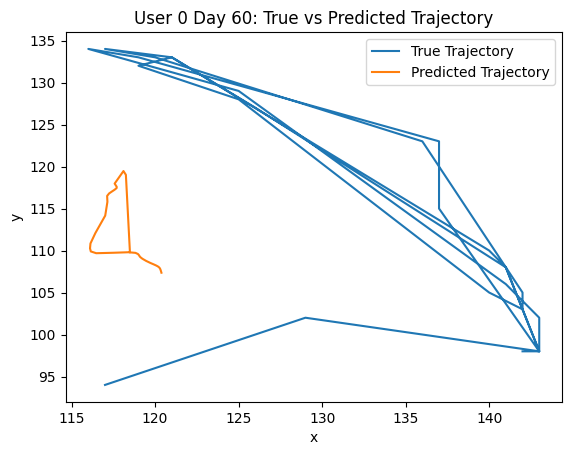

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assumes `data`, `all_preds`, and `HIST` are already in memory
user_idx = 0
day_idx = 0  # 0 → day 60, change to 1–14 for subsequent days

# Extract true vs predicted for that user and day
true_day = data[user_idx, HIST + day_idx*48 : HIST + (day_idx+1)*48, :]  # shape (48,2)
pred_day = all_preds[user_idx, day_idx, :, :]                           # shape (48,2)

# Plot trajectories (x vs y)
plt.figure()
plt.plot(true_day[:, 0], true_day[:, 1], label='True Trajectory')
plt.plot(pred_day[:, 0], pred_day[:, 1], label='Predicted Trajectory')
plt.title(f'User {user_idx} Day {60 + day_idx}: True vs Predicted Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Parameters / existing vars:
#   uids       : array of your user‐IDs in the same order as data/all_preds
#   data       : NumPy array, shape = (U, T_all, 2)
#   all_preds  : NumPy array, shape = (U, 15, 48, 2)
#   HIST       : int = 60 * 48

rows = []
U, D, S, _ = all_preds.shape   # U=6000, D=15 days, S=48 slots
for i, uid in enumerate(uids):
    for d in range(D):
        for t in range(S):
            true_x, true_y = data[i, HIST + d*S + t]   # true days 60–74
            pred_x, pred_y = all_preds[i, d, t]
            rows.append({
                'uid':           uid,
                'd':             60 + d,    # day index
                't':             t,         # slot index (0–47)
                'True_x':        true_x,
                'Predicted_x':   pred_x,
                'True_y':        true_y,
                'Predicted_y':   pred_y,
            })

df_preds = pd.DataFrame(rows)
print(df_preds.head())


   uid   d  t  True_x  Predicted_x  True_y  Predicted_y
0    0  60  0   117.0   118.490952    94.0   109.810982
1    0  60  1   117.0   118.249275    94.0   119.011101
2    0  60  2   117.0   118.104622    94.0   119.460968
3    0  60  3   117.0   117.576065    94.0   117.967751
4    0  60  4   117.0   117.699509    94.0   117.586266


In [ ]:
df_preds.to_csv('predictions.csv', index=False)

In [ ]:
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Result Section

In [ ]:
import pandas as pd
df_rf = pd.read_csv('rf-prediction.csv')
df_lstm = pd.read_csv('lstm-prediction.csv')
# df_rnn = pd.read_csv('rnn-prediction.csv')
df_rnn = pd.read_csv('rnn-prediction.csv')

In [ ]:
print(df_rf.shape)
print(df_lstm.shape)
print(df_rnn.shape)

(1721629, 7)
(4320000, 7)
(1661629, 9)


In [ ]:
df_rf = df_rf.sort_values(by=['uid', 'd', 't'], ascending=[True, True, True])
df_lstm = df_lstm.sort_values(by=['uid', 'd', 't'], ascending=[True, True, True])
df_rnn = df_rnn.sort_values(by=['uid', 'd', 't'], ascending=[True, True, True])
print(df_rf.head(15))
print(df_lstm.head(26))
print(df_rnn.head())

    uid   d   t  True_x  Predicted_x  True_y  Predicted_y
0     0  60  12     129          129     102           99
1     0  60  13     143          143      98           98
2     0  60  14     143          129     102          100
3     0  60  15     141          129     106           93
4     0  60  16     125          129     129           93
5     0  60  17     116          116     134          134
6     0  60  19     119          142     133          100
7     0  60  20     137          129     123           98
8     0  60  21     137          112     115          100
9     0  60  22     143          143      98           98
10    0  60  25     141          141     108          108
11    0  60  26     140          141     110          101
12    0  60  27     121          129     133           98
13    0  60  28     117          117     134           96
14    0  60  29     120          129     133           99
    uid   d   t  True_x  Predicted_x  True_y  Predicted_y
0     0  60   

In [ ]:
import numpy as np

for col in df_rf.columns:
    if pd.api.types.is_numeric_dtype(df_rf[col]):
        df_rf[col] = df_rf[col].round().astype(int)
for col in df_lstm.columns:
    if pd.api.types.is_numeric_dtype(df_lstm[col]):
        df_lstm[col] = df_lstm[col].round().astype(int)

df_rnn = df_rnn.replace([np.inf, -np.inf], np.nan)
df_rnn = df_rnn.dropna()
for col in df_rnn.columns:
    if pd.api.types.is_numeric_dtype(df_rnn[col]):
        df_rnn[col] = df_rnn[col].round().astype(int)
df_rnn = df_rnn.rename(columns={
    'true_x': 'True_x',
    'true_y': 'True_y',
    'pred_x': 'Predicted_x',
    'pred_y': 'Predicted_y'
})
df_rnn = df_rnn[[
    'uid',
    'd',
    't',
    'True_x',
    'Predicted_x',
    'True_y',
    'Predicted_y'
]]

In [ ]:
print(df_rf.head(15))
print(df_lstm.head(26))
print(df_rnn.head())

    uid   d   t  True_x  Predicted_x  True_y  Predicted_y
0     0  60  12     129          129     102           99
1     0  60  13     143          143      98           98
2     0  60  14     143          129     102          100
3     0  60  15     141          129     106           93
4     0  60  16     125          129     129           93
5     0  60  17     116          116     134          134
6     0  60  19     119          142     133          100
7     0  60  20     137          129     123           98
8     0  60  21     137          112     115          100
9     0  60  22     143          143      98           98
10    0  60  25     141          141     108          108
11    0  60  26     140          141     110          101
12    0  60  27     121          129     133           98
13    0  60  28     117          117     134           96
14    0  60  29     120          129     133           99
    uid   d   t  True_x  Predicted_x  True_y  Predicted_y
0     0  60   

In [ ]:
df_merged = df_rf.merge(
    df_lstm,
    on=['uid','d','t'],
    how='inner',
    suffixes=('_rf','_lstm')
)
print(df_merged)

          uid   d   t  True_x_rf  Predicted_x_rf  True_y_rf  Predicted_y_rf  \
0           0  60  12        129             129        102              99   
1           0  60  13        143             143         98              98   
2           0  60  14        143             129        102             100   
3           0  60  15        141             129        106              93   
4           0  60  16        125             129        129              93   
...       ...  ..  ..        ...             ...        ...             ...   
1721624  5999  74  37         97              97        121             108   
1721625  5999  74  38        110              93        120             117   
1721626  5999  74  39        111             165        111             111   
1721627  5999  74  46        110             101        110             104   
1721628  5999  74  47        110             101        110             104   

         True_x_lstm  Predicted_x_lstm  True_y_lstm

In [ ]:
df_merged = df_merged.merge(
    df_rnn,
    on=['uid','d','t'],
    how='inner',
    suffixes=('_rf','_rnn')
)
print(df_merged)

          uid   d   t  True_x_rf  Predicted_x_rf  True_y_rf  Predicted_y_rf  \
0           0  60  25        141             141        108             108   
1           0  60  26        140             141        110             101   
2           0  60  27        121             129        133              98   
3           0  60  28        117             117        134              96   
4           0  60  29        120             129        133              99   
...       ...  ..  ..        ...             ...        ...             ...   
1661624  5999  74  37         97              97        121             108   
1661625  5999  74  38        110              93        120             117   
1661626  5999  74  39        111             165        111             111   
1661627  5999  74  46        110             101        110             104   
1661628  5999  74  47        110             101        110             104   

         True_x_lstm  Predicted_x_lstm  True_y_lstm

In [ ]:
import numpy as np

# assuming your merged DataFrame is named `df`
# RF errors
err_x_rf = np.abs(df_merged['True_x_rf'] - df_merged['Predicted_x_rf'])
err_y_rf = np.abs(df_merged['True_y_rf'] - df_merged['Predicted_y_rf'])
mae_x_rf = err_x_rf.mean()
mae_y_rf = err_y_rf.mean()
mae_rf   = np.mean([mae_x_rf, mae_y_rf])

# LSTM errors
err_x_lstm = np.abs(df_merged['True_x_lstm'] - df_merged['Predicted_x_lstm'])
err_y_lstm = np.abs(df_merged['True_y_lstm'] - df_merged['Predicted_y_lstm'])
mae_x_lstm = err_x_lstm.mean()
mae_y_lstm = err_y_lstm.mean()
mae_lstm   = np.mean([mae_x_lstm, mae_y_lstm])

# RNN errors
err_x_rnn = np.abs(df_merged['True_x'] - df_merged['Predicted_x'])
err_y_rnn = np.abs(df_merged['True_y'] - df_merged['Predicted_y'])
mae_x_rnn = err_x_rnn.mean()
mae_y_rnn = err_y_rnn.mean()
mae_rnn   = np.mean([mae_x_rnn, mae_y_rnn])

print(f"RF MAE → x: {mae_x_rf:.4f}, y: {mae_y_rf:.4f}, combined: {mae_rf:.4f}")
print(f"LSTM MAE → x: {mae_x_lstm:.4f}, y: {mae_y_lstm:.4f}, combined: {mae_lstm:.4f}")
print(f"RNN MAE → x: {mae_x_rnn:.4f}, y: {mae_y_rnn:.4f}, combined: {mae_rnn:.4f}")

RF MAE → x: 23.4481, y: 21.2156, combined: 22.3319
LSTM MAE → x: 10.0023, y: 10.2822, combined: 10.1422
RNN MAE → x: 4.5438, y: 3.8465, combined: 4.1952


In [ ]:
# TWO MODELS (RF+LSTM)
# import numpy as np
# import pandas as pd

# # assume your merged DataFrame is called `df` and has columns:
# #   True_x_rf, Predicted_x_rf, True_y_rf, Predicted_y_rf
# #   True_x_lstm, Predicted_x_lstm, True_y_lstm, Predicted_y_lstm

# # 1) Pull out NumPy arrays for “true” and each model’s preds
# true = df_merged[['True_x_rf','True_y_rf']].values               # shape (N,2)
# pred_rf   = df_merged[['Predicted_x_rf','Predicted_y_rf']].values
# pred_lstm = df_merged[['Predicted_x_lstm','Predicted_y_lstm']].values

# # 2) Grid‐search over weights w ∈ [0,1] for RF vs (1−w)·LSTM
# best_w, best_mae = None, float('inf')
# for w in np.linspace(0,1,101):
#     ens = w*pred_rf + (1-w)*pred_lstm
#     mae = np.mean(np.abs(ens - true))
#     if mae < best_mae:
#         best_mae, best_w = mae, w

# print(f"Best RF‐weight = {best_w:.2f} → Ensemble MAE = {best_mae:.4f}")

# # 3) Apply that weight and add ensemble columns back to your DataFrame
# df_merged['Predicted_x_ens'] = best_w*df_merged['Predicted_x_rf']   + (1-best_w)*df_merged['Predicted_x_lstm']
# df_merged['Predicted_y_ens'] = best_w*df_merged['Predicted_y_rf']   + (1-best_w)*df_merged['Predicted_y_lstm']

# # 4) (Optional) Check per‐coordinate MAE
# mae_x = np.mean(np.abs(df_merged['True_x_rf'] - df_merged['Predicted_x_ens']))
# mae_y = np.mean(np.abs(df_merged['True_y_rf'] - df_merged['Predicted_y_ens']))
# print(f"Ensemble MAE_x = {mae_x:.4f}, MAE_y = {mae_y:.4f}")


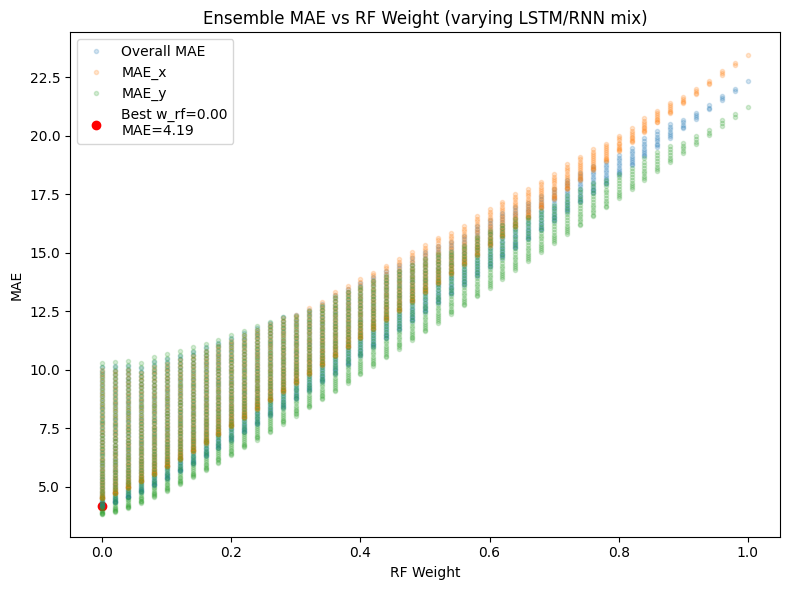

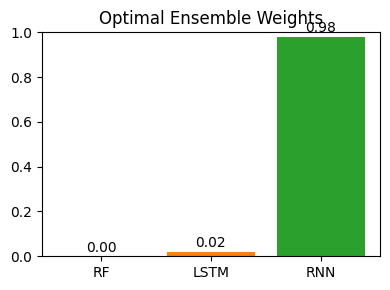

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Recompute the sweep results
true      = df_merged[['True_x_rf','True_y_rf']].values
pred_rf   = df_merged[['Predicted_x_rf','Predicted_y_rf']].values
pred_lstm = df_merged[['Predicted_x_lstm','Predicted_y_lstm']].values
pred_rnn  = df_merged[['Predicted_x','Predicted_y']].values

w_vals = np.linspace(0,1,51)
mae_all = []
mae_x   = []
mae_y   = []
ws      = []

for wr in w_vals:
    for wl in w_vals:
        wrn = 1 - wr - wl
        if wrn < 0: continue
        ens = wr*pred_rf + wl*pred_lstm + wrn*pred_rnn
        err = np.abs(ens - true)
        mae_all.append(err.mean())
        mae_x.append(err[:,0].mean())
        mae_y.append(err[:,1].mean())
        ws.append((wr, wl, wrn))

mae_all = np.array(mae_all)
mae_x   = np.array(mae_x)
mae_y   = np.array(mae_y)
ws      = np.array(ws)

best_idx   = mae_all.argmin()
best_wr, best_wl, best_wrn = ws[best_idx]

# Plot MAE curves vs. RF weight
plt.figure(figsize=(8,6))
plt.plot(ws[:,0], mae_all, '.', alpha=0.2, label='Overall MAE')
plt.plot(ws[:,0], mae_x,   '.', alpha=0.2, label='MAE_x')
plt.plot(ws[:,0], mae_y,   '.', alpha=0.2, label='MAE_y')
plt.scatter([best_wr], [mae_all[best_idx]], c='red', label=f'Best w_rf={best_wr:.2f}\nMAE={mae_all[best_idx]:.2f}')
plt.xlabel('RF Weight')
plt.ylabel('MAE')
plt.title('Ensemble MAE vs RF Weight (varying LSTM/RNN mix)')
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart of best weights
plt.figure(figsize=(4,3))
plt.bar(['RF','LSTM','RNN'], [best_wr, best_wl, best_wrn], color=['C0','C1','C2'])
for i, w in enumerate([best_wr, best_wl, best_wrn]):
    plt.text(i, w + 0.02, f'{w:.2f}', ha='center')
plt.ylim(0,1)
plt.title('Optimal Ensemble Weights')
plt.tight_layout()
plt.show()


In [ ]:
# TWO MODELS (RF+LSTM)
# import numpy as np
# import matplotlib.pyplot as plt

# # Extract arrays from the existing DataFrame `df`
# true_x      = df_merged['True_x_rf'].values
# true_y      = df_merged['True_y_rf'].values
# pred_x_rf   = df_merged['Predicted_x_rf'].values
# pred_y_rf   = df_merged['Predicted_y_rf'].values
# pred_x_lstm = df_merged['Predicted_x_lstm'].values
# pred_y_lstm = df_merged['Predicted_y_lstm'].values

# # Grid of weights
# w_grid = np.linspace(0, 1, 101)
# mae_all = []
# mae_x   = []
# mae_y   = []

# for w in w_grid:
#     ens_x = w * pred_x_rf + (1 - w) * pred_x_lstm
#     ens_y = w * pred_y_rf + (1 - w) * pred_y_lstm
#     mae_x.append(np.mean(np.abs(ens_x - true_x)))
#     mae_y.append(np.mean(np.abs(ens_y - true_y)))
#     mae_all.append((mae_x[-1] + mae_y[-1]) / 2)  # average of x and y MAEs

# mae_all = np.array(mae_all)
# mae_x   = np.array(mae_x)
# mae_y   = np.array(mae_y)

# # Find best weight for overall MAE
# best_idx      = np.argmin(mae_all)
# best_w        = w_grid[best_idx]
# best_mae_all  = mae_all[best_idx]
# best_mae_x    = mae_x[best_idx]
# best_mae_y    = mae_y[best_idx]

# # Plot MAE curves
# plt.figure(figsize=(8, 6))
# plt.plot(w_grid, mae_all, label='Overall MAE')
# plt.plot(w_grid, mae_x,   label='MAE_x')
# plt.plot(w_grid, mae_y,   label='MAE_y')
# plt.axvline(best_w, color='r', linestyle='--',
#             label=f'Best w={best_w:.2f}\nMAE_all={best_mae_all:.2f}\n'
#                   f'MAE_x={best_mae_x:.2f}\nMAE_y={best_mae_y:.2f}')
# plt.xlabel('Weight on RF model')
# plt.ylabel('Mean Absolute Error')
# plt.title('Ensemble MAE vs RF Weight')
# plt.legend()
# plt.tight_layout()
# plt.show()

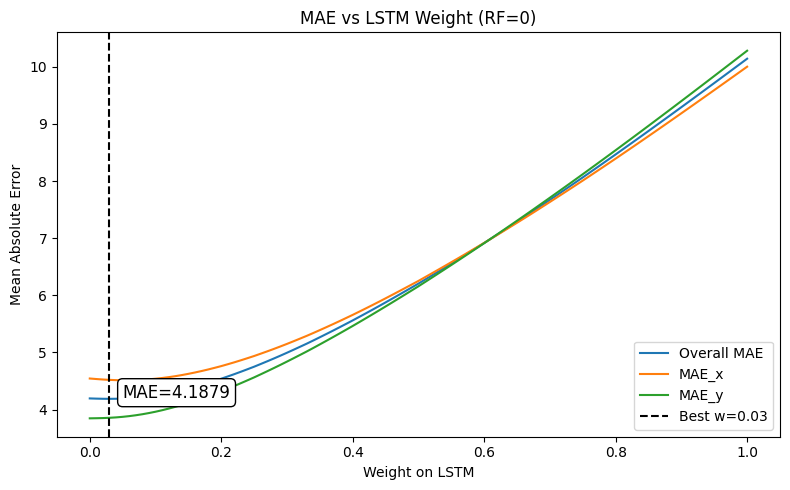

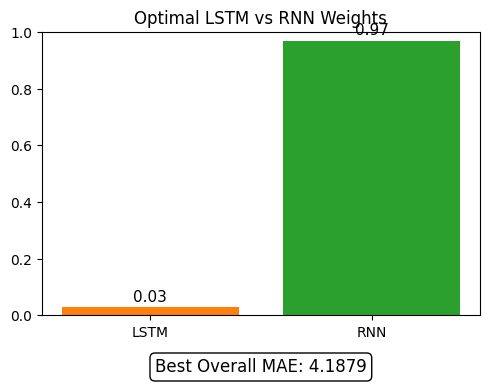

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pull arrays from df_merged
true      = df_merged[['True_x_rf','True_y_rf']].values
pred_lstm = df_merged[['Predicted_x_lstm','Predicted_y_lstm']].values
pred_rnn  = df_merged[['Predicted_x','Predicted_y']].values

# Sweep LSTM vs RNN weights (RF=0)
w_vals = np.linspace(0, 1, 101)
mae_all = []
mae_x   = []
mae_y   = []

for w in w_vals:
    ens = w * pred_lstm + (1 - w) * pred_rnn
    err = np.abs(ens - true)
    mae_all.append(err.mean())
    mae_x.append(err[:,0].mean())
    mae_y.append(err[:,1].mean())

mae_all = np.array(mae_all)
mae_x   = np.array(mae_x)
mae_y   = np.array(mae_y)

# Find best weight & MAE
best_idx    = mae_all.argmin()
best_w      = w_vals[best_idx]
best_mae_all = mae_all[best_idx]
best_mae_x   = mae_x[best_idx]
best_mae_y   = mae_y[best_idx]

# --- Plot MAE vs LSTM weight ---
plt.figure(figsize=(8,5))
plt.plot(w_vals, mae_all, label='Overall MAE')
plt.plot(w_vals, mae_x,   label='MAE_x')
plt.plot(w_vals, mae_y,   label='MAE_y')
plt.axvline(best_w, color='k', linestyle='--', label=f'Best w={best_w:.2f}')
# Annotate best MAE on the chart
plt.text(best_w + 0.02, best_mae_all + 0.02,
         f'MAE={best_mae_all:.4f}',
         fontsize=12, color='k',
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.xlabel('Weight on LSTM')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs LSTM Weight (RF=0)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Bar chart of optimal weights & MAE ---
plt.figure(figsize=(5,4))
labels = ['LSTM','RNN']
weights = [best_w, 1-best_w]
plt.bar(labels, weights, color=['C1','C2'])
for i, (lbl, wt) in enumerate(zip(labels, weights)):
    plt.text(i, wt + 0.02, f'{wt:.2f}', ha='center', fontsize=11)
# Display best MAE below
plt.text(0.5, -0.15, f'Best Overall MAE: {best_mae_all:.4f}',
         ha='center', va='top', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.ylim(0,1)
plt.title('Optimal LSTM vs RNN Weights')
plt.tight_layout()
plt.show()


In [ ]:
best_mae_all

np.float64(4.187942732703867)

In [ ]:
# Compute RNN weight
w_lstm = best_w
w_rnn  = 1 - best_w

# Add weighted‐ensemble predictions
df_merged['Predicted_x_weighted'] = (
    w_lstm * df_merged['Predicted_x_lstm']
  + w_rnn  * df_merged['Predicted_x']
)
df_merged['Predicted_y_weighted'] = (
    w_lstm * df_merged['Predicted_y_lstm']
  + w_rnn  * df_merged['Predicted_y']
)

In [ ]:
# Round the weighted predictions to the nearest integer
df_merged['Predicted_x_weighted'] = df_merged['Predicted_x_weighted'].round().astype(int)
df_merged['Predicted_y_weighted'] = df_merged['Predicted_y_weighted'].round().astype(int)
df_merged.head()

,uid,d,t,True_x_rf,Predicted_x_rf,True_y_rf,Predicted_y_rf,True_x_lstm,Predicted_x_lstm,True_y_lstm,Predicted_y_lstm,True_x,Predicted_x,True_y,Predicted_y,Predicted_x_weighted,Predicted_y_weighted
0,0,60,25,141,141,108,108,141,119,108,109,141,142,108,93,141,93
1,0,60,26,140,141,110,101,140,120,110,109,140,137,110,109,136,109
2,0,60,27,121,129,133,98,121,120,133,108,121,137,133,108,136,108
3,0,60,28,117,117,134,96,117,120,134,108,117,114,134,137,114,136
4,0,60,29,120,129,133,99,120,120,133,108,120,114,133,133,114,132


In [ ]:
# df_merged = df_merged.drop(columns=['True_y_lstm', 'True_y_lstm', 'True_x', 'True_y'])
df_merged = df_merged.drop(columns=['True_x_lstm'])
df_merged.head()

,uid,d,t,True_x_rf,Predicted_x_rf,True_y_rf,Predicted_y_rf,Predicted_x_lstm,Predicted_y_lstm,Predicted_x,Predicted_y,Predicted_x_weighted,Predicted_y_weighted
0,0,60,25,141,141,108,108,119,109,142,93,141,93
1,0,60,26,140,141,110,101,120,109,137,109,136,109
2,0,60,27,121,129,133,98,120,108,137,108,136,108
3,0,60,28,117,117,134,96,120,108,114,137,114,136
4,0,60,29,120,129,133,99,120,108,114,133,114,132


In [ ]:
# df_merged = df_merged.rename(columns={
#     'Predicted_x': 'Predicted_x_rnn',
#     'Predicted_y': 'Predicted_y_rnn'
# })
df_merged = df_merged[[
    'uid',
    'd',
    't',
    'True_x',
    'True_y',
    'Predicted_x_rf',
    'Predicted_y_rf',
    'Predicted_x_lstm',
    'Predicted_y_lstm',
    'Predicted_x_rnn',
    'Predicted_y_rnn',
    'Predicted_x_weighted',
    'Predicted_y_weighted',
]]
df_merged.head()

,uid,d,t,True_x,True_y,Predicted_x_rf,Predicted_y_rf,Predicted_x_lstm,Predicted_y_lstm,Predicted_x_rnn,Predicted_y_rnn,Predicted_x_weighted,Predicted_y_weighted
0,0,60,25,141,108,141,108,119,109,142,93,141,93
1,0,60,26,140,110,141,101,120,109,137,109,136,109
2,0,60,27,121,133,129,98,120,108,137,108,136,108
3,0,60,28,117,134,117,96,120,108,114,137,114,136
4,0,60,29,120,133,129,99,120,108,114,133,114,132


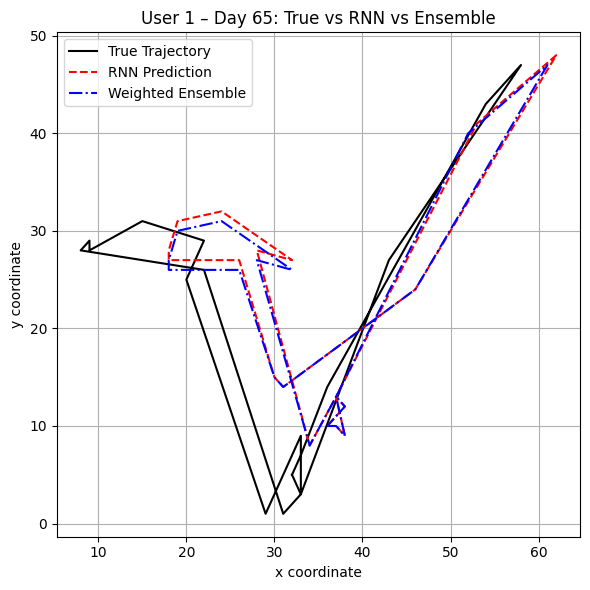

In [ ]:
import matplotlib.pyplot as plt # (1,65,66)
user_idx = 1    # index of the user to plot; adjust as needed
day_num  = 65   # day to visualize (e.g., 60 for first predicted day)
df_ud = df_merged[(df_merged['uid'] == user_idx) & (df_merged['d'] == day_num)]
true_xy = df_ud[['True_x','True_y']].values
rnn_xy  = df_ud[['Predicted_x_rnn','Predicted_y_rnn']].values
ens_xy  = df_ud[['Predicted_x_weighted','Predicted_y_weighted']].values
plt.figure(figsize=(6,6))
plt.plot(true_xy[:,0], true_xy[:,1], 'k-',  label='True Trajectory')
plt.plot(rnn_xy[:,0],  rnn_xy[:,1],  'r--', label='RNN Prediction')
plt.plot(ens_xy[:,0],  ens_xy[:,1],  'b-.', label='Weighted Ensemble')
plt.title(f'User {user_idx} – Day {day_num}: True vs RNN vs Ensemble')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

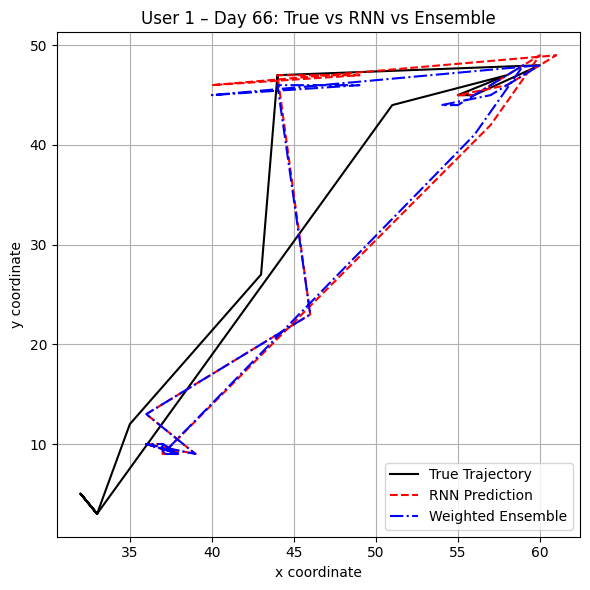

In [ ]:
import matplotlib.pyplot as plt # (1,65,66)
user_idx = 1    # index of the user to plot; adjust as needed
day_num  = 66   # day to visualize (e.g., 60 for first predicted day)
df_ud = df_merged[(df_merged['uid'] == user_idx) & (df_merged['d'] == day_num)]
true_xy = df_ud[['True_x','True_y']].values
rnn_xy  = df_ud[['Predicted_x_rnn','Predicted_y_rnn']].values
ens_xy  = df_ud[['Predicted_x_weighted','Predicted_y_weighted']].values
plt.figure(figsize=(6,6))
plt.plot(true_xy[:,0], true_xy[:,1], 'k-',  label='True Trajectory')
plt.plot(rnn_xy[:,0],  rnn_xy[:,1],  'r--', label='RNN Prediction')
plt.plot(ens_xy[:,0],  ens_xy[:,1],  'b-.', label='Weighted Ensemble')
plt.title(f'User {user_idx} – Day {day_num}: True vs RNN vs Ensemble')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_merged.to_csv('predictions.csv', index=False)
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>